<a href="https://colab.research.google.com/github/MohamedToukabri/MohamedToukabri/blob/main/Image_denoising_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import skimage as ski 

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist

# Introduction

The goal of image denoising methods is to recover the
original image from a noisy measurement,
$v(i) = u(i) + n(i)$ 
where $v(i)$ is the observed value, $u(i)$is the “true” value and
$n(i)$ is the noise perturbation at a pixel i. The best simple
way to model the effect of noise on a digital image is to add
a gaussian white noise. In that case, $n(i)$ are i.i.d. gaussian
values with zero mean and variance $σ²$
Formally we define a denoising method Dh as a decomposition
$v = Dhv + n(Dh, v)$,
where $v$ is the noisy image and h is a filtering parameter which usually depends on the standard deviation of the
noise. Ideally, Dhv is smoother than $v$ and $n(Dh, v)$ looks
like the realization of a white noise.

In [3]:
#importing data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


Text(0.5, 1.0, 'A hand-written digit')

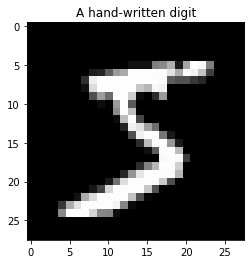

In [ ]:
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.title('A hand-written digit')

In [13]:
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
X_train = X_train / 255
X_test = X_test / 255

In [14]:
#noising the images
noise_factor = 0.2
x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [16]:
X_test = np.reshape(X_test, (10000,28,28)) *255
x_test_noisy = np.reshape(x_test_noisy, (-1,28,28)) *255

Text(0.5, 1.0, 'A noisy hand-written digit')

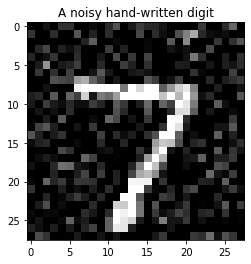

In [17]:
noisy_image=x_test_noisy[0] 
plt.imshow(noisy_image, cmap=plt.get_cmap('gray'))
plt.title('A noisy hand-written digit')

# Non-local Means

**First suggested Solution : Non-local means** \\
Non-local means is an algorithm in image processing for image denoising. 
The denoising is done by computing the average color of these most resembling pixels. The resemblance is evaluated by comparing a whole window around each pixel, and not just the color. This
new filter is the **non-local means** and it writes
$NLu(p) = \frac{1}{/C(p)}\ 
∫
f(d(B(p), B(q)) u(q) dq$ 
  where $d(B(p), B(q))$ is an Euclidean distance between image patches centered respectively at $p$ and
$q$, $f$ is a decreasing function and $C(p)$ is the normalizing factor

In [18]:
from skimage.restoration import denoise_nl_means, estimate_sigma

In [19]:
sigma_hat = np.mean(estimate_sigma(noisy_image))

In [20]:
#the patch is an area of a single image 
#the patch is used in order to include enough surrounding information
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6)  # 13x13 search area

The parametre **h** controls the smoothness of the image , this solution will be based on h variation.

In [21]:
#fast_algorithm
fast_denoised_image_h1 = denoise_nl_means(noisy_image, h=1 * sigma_hat, sigma=sigma_hat,
                                 fast_mode=True, **patch_kw)
fast_denoised_image_h2 = denoise_nl_means(noisy_image, h=1.5 * sigma_hat, sigma=sigma_hat,
                                 fast_mode=True, **patch_kw)

Text(0.5, 1.0, 'Denoised Image with h=1,5')

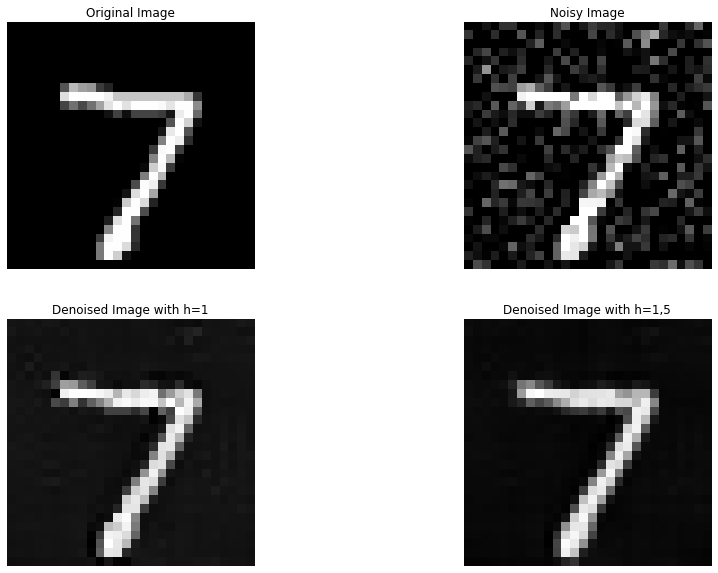

In [23]:
fig = plt.figure(figsize=(15,10))
columns = 2
rows = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title("Original Image")
fig.add_subplot(rows, columns, 2)
plt.imshow(noisy_image,cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title("Noisy Image")
fig.add_subplot(rows, columns, 3)
plt.imshow(fast_denoised_image_h1,cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title("Denoised Image with h=1")
fig.add_subplot(rows, columns, 4)
plt.imshow(fast_denoised_image_h2,cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title("Denoised Image with h=1,5")

# Auto-Enocders for image denoising

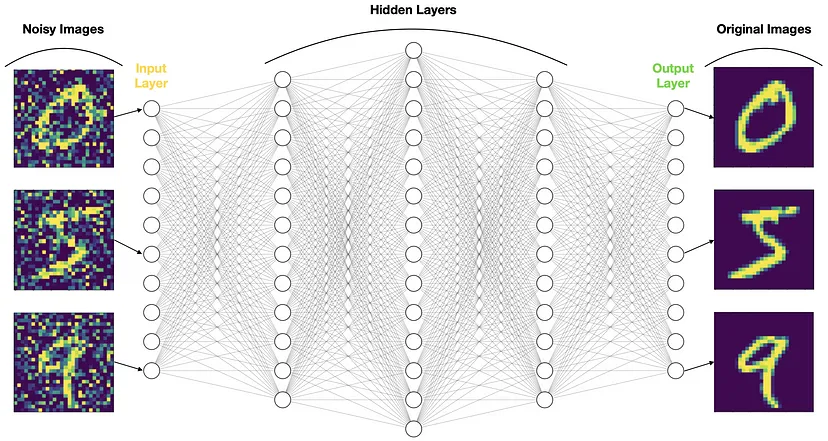

**Second suggested solution : Auto-Enocders for image denoising** \\
Autoencoder is an unsupervised artificial neural network that is trained to copy its input to output. In the case of image data, the autoencoder will first encode the image into a lower-dimensional representation, then decodes that representation back to the image. Encoder-Decoder automatically consists of the following two structures : \\


*   The encoder- This network downsamples the data into lower dimensions.
*   The decoder- This network reconstructs the original data from the lower dimension representation.
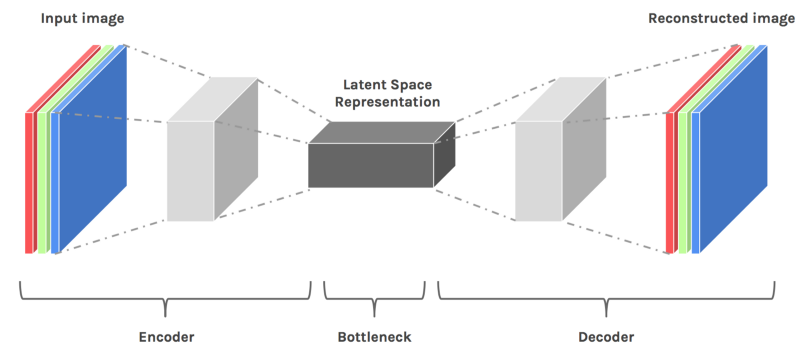



In [24]:
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
X_test = X_test / 255

In [25]:
#noising the images
x_test_noisy = x_test_noisy.reshape(X_test.shape[0], num_pixels).astype('float32')
x_test_noisy = x_test_noisy / 255

In [26]:
# create model
model = Sequential()
model.add(Dense(500, input_dim=num_pixels, activation='relu')) #
model.add(Dense(300, activation='relu')) 
model.add(Dense(100, activation='relu')) 
model.add(Dense(300, activation='relu')) 
model.add(Dense(500, activation='relu'))
model.add(Dense(784, activation='sigmoid'))

In [27]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [28]:
# Training model
model.fit(x_train_noisy, X_train, validation_data=(x_test_noisy, X_test), epochs=2, batch_size=200)

Epoch 1/2
300/300 [==============================] - 16s 47ms/step - loss: 0.0429 - val_loss: 7362.6094
Epoch 2/2
300/300 [==============================] - 13s 43ms/step - loss: 0.0174 - val_loss: 7357.9272


In [29]:
# Final evaluation of the model
pred = model.predict(x_test_noisy)

313/313 [==============================] - 2s 5ms/step


In [31]:
X_test = np.reshape(X_test, (10000,28,28)) *255
pred = np.reshape(pred, (10000,28,28)) *255
x_test_noisy = np.reshape(x_test_noisy, (-1,28,28)) *255

In [33]:
(X, Y), (x, y) = mnist.load_data()

Text(0.5, 1.0, 'Denoised Image using auto-encoders')

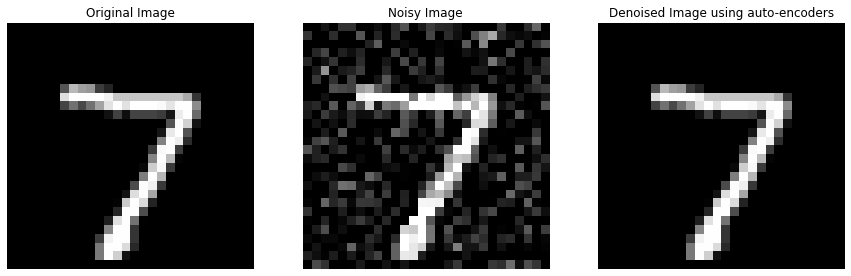

In [36]:
fig = plt.figure(figsize=(15,10))
columns = 3
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(x[0],cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title("Original Image")
fig.add_subplot(rows, columns, 2)
plt.imshow(x_test_noisy[0],cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title("Noisy Image")
fig.add_subplot(rows, columns, 3)
plt.imshow(X_test[0],cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title("Denoised Image using auto-encoders")

# Observations

**Observation** : \\
The first approach was efficient since we had a low Signal-to-noise ratio, and given the fact that it was sipmle , maybe naive and intutively cheaper to compute , it can be a good solution but that's not the case for a highly corrupted image. \\
On the other hand , the second solution was efficient too but hard to compute and to understand. We can spot a small bluriness but it can be fixed by increasing the number of epochs.

# References

1-Non-Local Means Denoising by
Antoni Buades
, Bartomeu Coll
, Jean-Michel Morel \\
2-Autoencoder For Denoising Images by Michel Kana

# Credits

This work was elaborated by : Mohamed Toukabri , Melek Walha and Wissem Chiha